<a href="https://colab.research.google.com/github/NicolasMlicotta/california-housing-regression/blob/main/california_housing_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción del valor medio de viviendas en California

## Contexto

Este proyecto utiliza el dataset **California Housing**, derivado del censo de 1990 del estado de California, para predecir el **valor medio de la vivienda por bloque censal**. Las variables disponibles incluyen características socioeconómicas y geográficas como ingreso medio, cantidad promedio de habitaciones y coordenadas geográficas.

## Objetivo

El objetivo es desarrollar modelos de regresión que permitan estimar con precisión el valor medio de la vivienda a partir de estas variables, evaluando y comparando distintos algoritmos para identificar el enfoque más eficaz.

Se parte de un modelo lineal como baseline, y se exploran modelos más complejos y robustos como Random Forest y Gradient Boosting para mejorar la performance.

---


In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.inspection import permutation_importance

In [2]:
dataset = fetch_california_housing(as_frame=True)
df = pd.concat([dataset.data, dataset.target.rename("target")], axis=1)
print(dataset.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [3]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [5]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [6]:
df.isnull().sum()
#No se encuentran valores nulos en el dataset

,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0
target,0


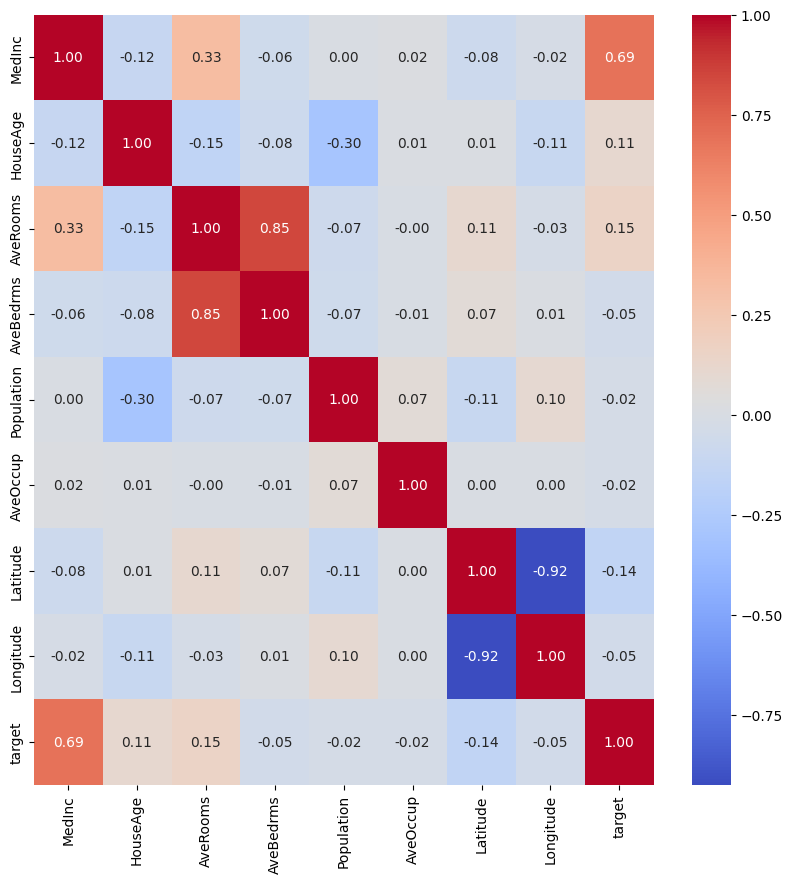

In [7]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [8]:
df.corr()["target"].sort_values(ascending=False)

,target
target,1.000000
MedInc,0.688075
AveRooms,0.151948
HouseAge,0.105623
AveOccup,-0.023737
Population,-0.024650
Longitude,-0.045967
AveBedrms,-0.046701
Latitude,-0.144160


MedInc (median income in block group) es la variable con una correlación más fuerte a la variable objetivo (valor de la vivienda).
Le siguen AveRooms y HouseAge con una correlación moderada a leve.
El resto de las variables, a pesar de tener una correlación débil, no serán eliminadas porque podrían aportar valor en conjunto o en modelos no lineales.

<Axes: xlabel='target', ylabel='Count'>

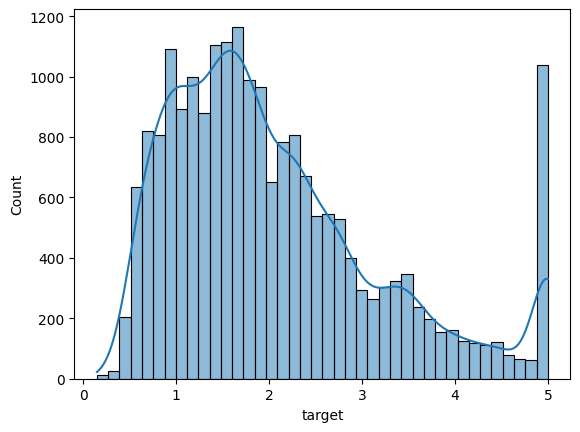

In [9]:
sns.histplot(df["target"], bins=40, kde=True)

La variable objetivo (`target`) presenta una distribución sesgada hacia la derecha, con una concentración de valores entre $100.000 y $300.000. Se observa un pico artificial en el valor 5.0, correspondiente a $500.000, que representa un tope aplicado en los datos del censo original. La distribución no es normal, por lo que modelos como regresión lineal podrían tener limitaciones sin transformaciones previas.

<Axes: xlabel='target'>

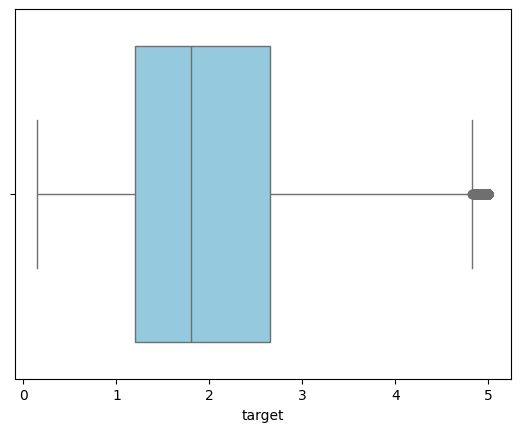

In [10]:
sns.boxplot(x=df["target"], color="skyblue")

El boxplot del valor medio de la vivienda muestra que la mediana se sitúa alrededor de los $200.000, con la mayoría de los datos concentrados entre $150.000 y $280.000. Se observan los outliers en la zona de $500.000 debido al tope mencionado anteriormente.


<Axes: xlabel='target', ylabel='MedInc'>

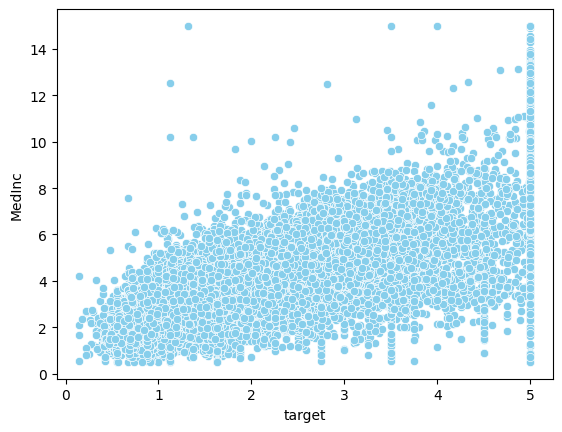

In [11]:
#MedInc vs Target
sns.scatterplot(data=df, x="target", y="MedInc", color="skyblue")

El gráfico de dispersión entre el valor medio de la vivienda (`target`) y el ingreso medio (`MedInc`) muestra una clara relación positiva: a mayor ingreso, mayor valor de las propiedades. Se observa también una acumulación artificial en `target = 5.0`, correspondiente al límite superior impuesto por el dataset original. Esta visualización refuerza el papel clave que cumple `MedInc` como predictor en los modelos de regresión.


<Axes: xlabel='MedInc'>

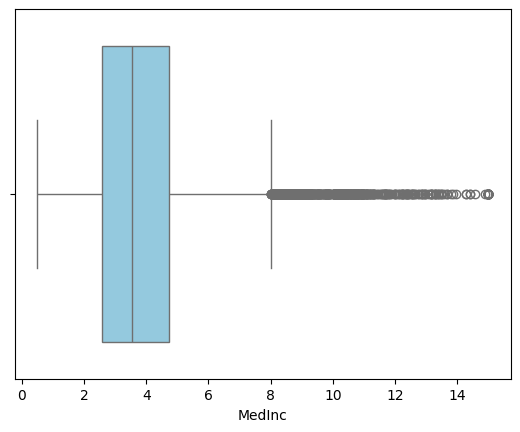

In [12]:
sns.boxplot(x = df["MedInc"], color="skyblue" )

El boxplot de `MedInc` muestra que el ingreso medio por bloque censal se concentra principalmente entre $25.000 y $50.000, con una mediana alrededor de $35.000. Se observa una cola de outliers hacia la derecha, correspondiente a bloques con ingresos considerablemente más altos, lo que sugiere la existencia de zonas de alto poder adquisitivo. Esta asimetría puede influir en la relación con el valor medio de la vivienda y será tenida en cuenta durante el modelado.

# Entrenamiento de modelos
Como estrategia se utilizarán:
- **Regresión lineal**: baseline
- **Random Forest:** benchmark
- **Gradient Boosting:** optimizar rendimientos sobre RF

In [13]:
#Preparación de los conjuntos de entrenamiento y test
X = df.drop("target", axis = 1)
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
#Se escalan las variables, media = 0 y desvío standard = 1
scaler = StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
#Regresión lineal: entrenamiento y evaluación del modelo
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

rmse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"RMSE Regresión Lineal: {rmse_lr}") #Root Mean Squared Error. Misma unidad que la variable objetivo
print(f"R2 Regresión Lineal: {r2_lr}") #R² Coeficiente de determinación = porcentaje de la varianza del target es explicada por el modelo.

RMSE Regresión Lineal: 0.5558915986952442
R2 Regresión Lineal: 0.575787706032451


La regresión lineal obtiene un RMSE de aproximadamente $55.600 y un R² de 0.576, lo que indica que el modelo explica cerca del 57.6% de la variabilidad en el valor medio de la vivienda. Si bien el modelo logra capturar cierta relación entre las variables independientes y el target, el nivel de error es relativamente alto, especialmente considerando el valor medio de las viviendas (~$200.000). Esto sugiere que el modelo lineal, si bien útil como baseline, tiene limitaciones para captar relaciones más complejas en los datos, lo que justifica explorar modelos más robustos como Random Forest o Gradient Boosting.


In [16]:
#Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train) #No necesita escalado
y_pred_rf = rf.predict(X_test)

rmse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"RMSE Random Forest: {rmse_rf}")
print(f"R2 Random Forest: {r2_rf}")

RMSE Random Forest: 0.2553684927247781
R2 Random Forest: 0.8051230593157366


In [17]:
#Gradient Boosting
gb = HistGradientBoostingRegressor(random_state = 42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

rmse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"RMSE Gradient Boosting: {rmse_gb}")
print(f"R2 Gradient Boosting: {r2_gb}")

RMSE Gradient Boosting: 0.21550450569807464
R2 Gradient Boosting: 0.8355440864062386


In [18]:
results = pd.DataFrame({
    "Modelo": ["Linear Regression", "Random Forest", "Gradient Boosting"],
    "RMSE": [rmse_lr, rmse_rf, rmse_gb],
    "R2": [r2_lr, r2_rf, r2_gb]
})

results.sort_values("RMSE")

,Modelo,RMSE,R2
2,Gradient Boosting,0.215505,0.835544
1,Random Forest,0.255368,0.805123
0,Linear Regression,0.555892,0.575788


**La regresión lineal**, utilizada como baseline, logra explicar aproximadamente un 57% de la variabilidad del target. Si bien es rápida y fácil de interpretar, presenta un error promedio (RMSE) elevado (~$55.600), lo cual limita su aplicabilidad práctica.

El modelo de **Random Forest** mejora notablemente la performance, reduciendo el RMSE en más de un 50% y alcanzando un R² de 0.805, gracias a su capacidad de capturar relaciones no lineales sin necesidad de escalar las variables.

Finalmente, **Gradient Boosting** se destaca como el **modelo más preciso**, con un RMSE de ~$21.550 y un R² de 0.836. Esto demuestra su capacidad superior para optimizar el ajuste del modelo.

**Limitaciones y próximos pasos**
- El dataset tiene un truncamiento en el target (tope en 5.0), lo que puede afectar la predicción en viviendas caras.
- No se aplicaron técnicas de regularización ni tuning de hiperparámetros.
- Una próxima mejora podría incluir eliminación de outliers y validación cruzada.


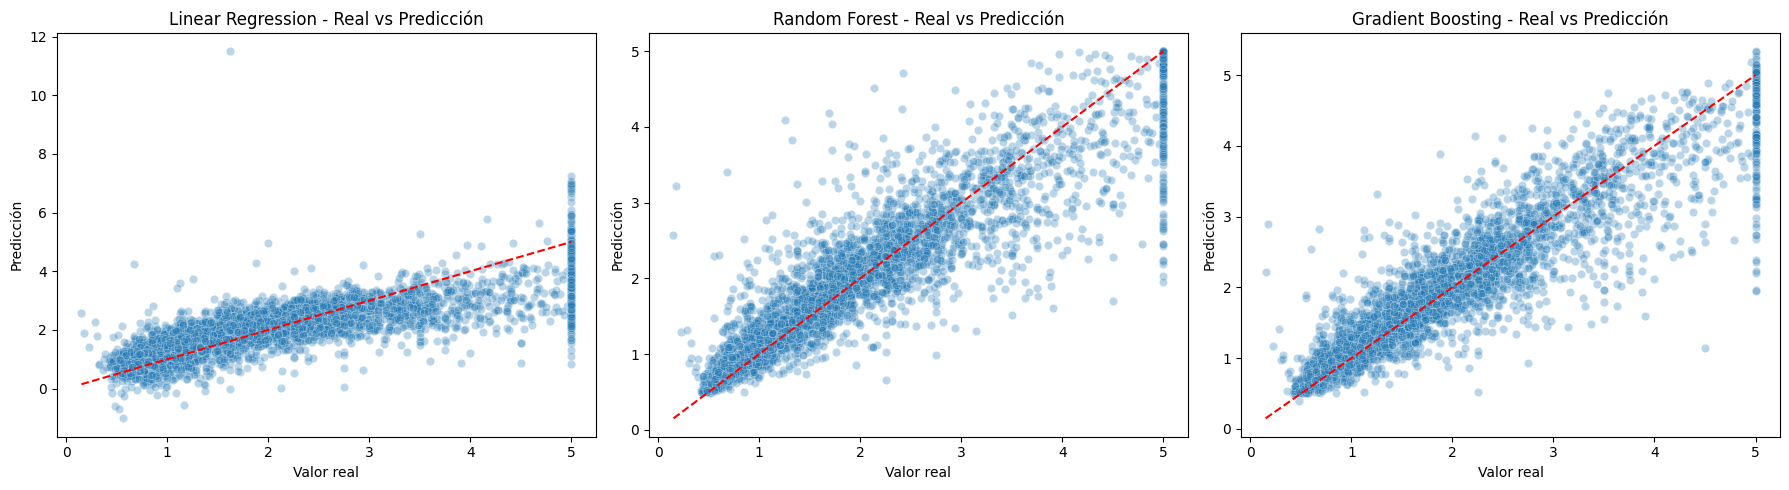

In [19]:
plt.figure(figsize=(18, 5))

# 1. Regresión Lineal
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Linear Regression - Real vs Predicción")

# 2. Random Forest
plt.subplot(1, 3, 2)
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Random Forest - Real vs Predicción")

# 3. Gradient Boosting
plt.subplot(1, 3, 3)
sns.scatterplot(x=y_test, y=y_pred_gb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Gradient Boosting - Real vs Predicción")

plt.tight_layout()
plt.show()



# Importancia de features en Random Forest y Gradient Boosting

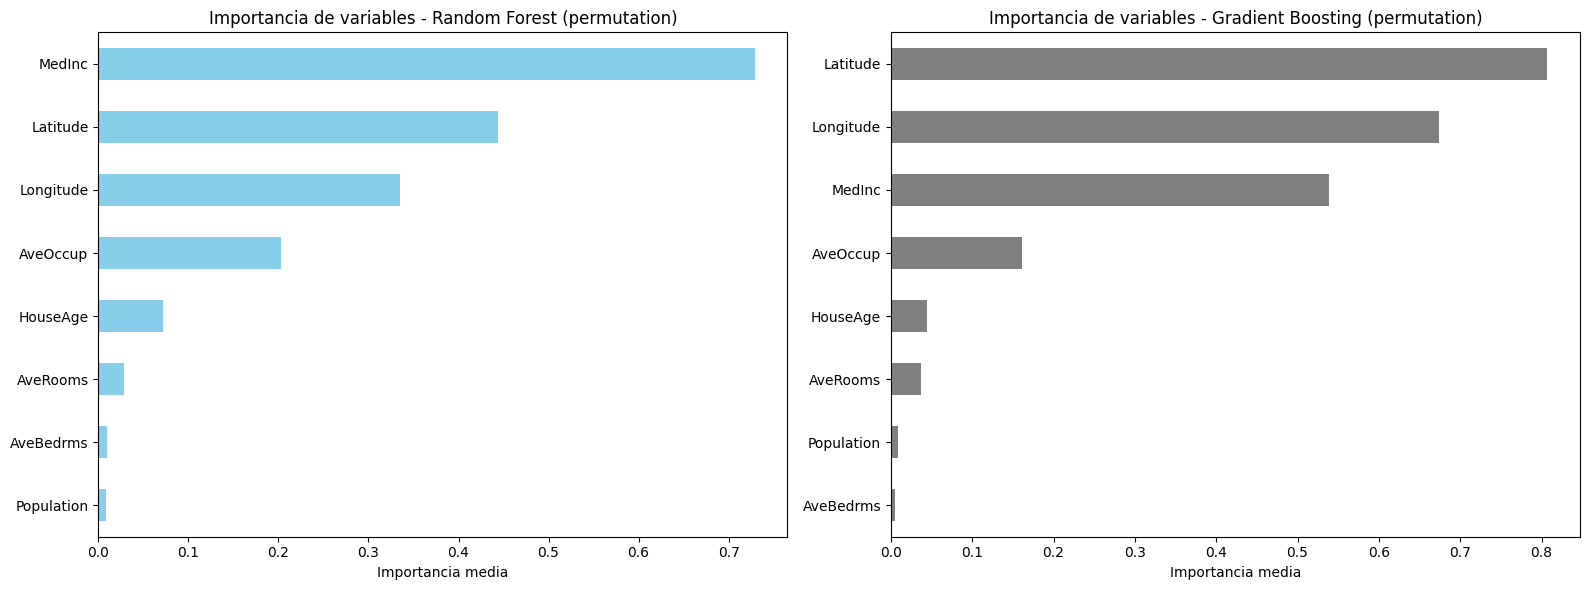

In [24]:
# Importancia por permutación RF
result_rf = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importances_rf = pd.Series(result_rf.importances_mean, index=X.columns).sort_values(ascending=True)

# Importancia por permutación GB
result_gb = permutation_importance(gb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importances_gb = pd.Series(result_gb.importances_mean, index=X.columns).sort_values(ascending=True)

# Visualización
plt.figure(figsize=(16, 6))

# Subplot 1: Random Forest
plt.subplot(1, 2, 1)
importances_rf.plot(kind="barh", color="skyblue")
plt.title("Importancia de variables - Random Forest (permutation)")
plt.xlabel("Importancia media")

# Subplot 2: Gradient Boosting
plt.subplot(1, 2, 2)
importances_gb.plot(kind="barh", color="gray")
plt.title("Importancia de variables - Gradient Boosting (permutation)")
plt.xlabel("Importancia media")

plt.tight_layout()
plt.show()
